In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import numpy as np
import matplotlib.patches as patches
from scipy.optimize import least_squares

In [3]:
filename = 'ksq_investigation.xlsx'
df = pd.read_excel(filename)
df.columns

Index(['wavelengths', 'eigAS', 'eigS', 'hGaN/lambda', 'Q_Nd1e15_A0',
       'Q_Nd1e15_S0', 'Q_Nd1e16_A0', 'Q_Nd1e16_S0', 'es.intWe_LL_A0',
       'solid.Wh_tot_LL_A0', 'es.intWe_LL_S0', 'solid.Wh_tot_LL_S0',
       'es.intWe_Nd1e15_A0', 'solid.Wh_tot_Nd1e15_A0', 'es.intWe_Nd1e15_S0',
       'solid.Wh_tot_Nd1e15_S0', 'es.intWe_Nd1e16_A0',
       'solid.Wh_tot_Nd1e16_A0', 'es.intWe_Nd1e16_S0',
       'solid.Wh_tot_Nd1e16_S0'],
      dtype='object')

In [4]:
#this data was gathered from the java script one at a time. 
undamped_data = {
    "lambda": [7.000E-06,8.000E-06,9.000E-06,1.000E-05,1.100E-05,1.200E-05,1.300E-05,1.400E-05,1.50E-05,1.60E-05,2.00E-05,2.60E-05,4.00E-05,8.00E-05],
    "hGan/Lambda": [0.63, 0.55, 0.49, 0.440, 0.400, 0.367, 0.338,0.314,0.293,0.275,0.220,0.169, .110,.055],
    "Antisymmetric ksq%": [0.055, 0.081, 0.103, 0.121, 0.134, 0.143, 0.148,0.150 ,0.152,0.149, 0.134,0.105,.064,.031],
    "Symmetric ksq%": [0.275, 0.358, 0.448, 0.533, 0.602, 0.643, 0.652,0.641,0.624,0.604,.56,.552,0.567,.576]
}
undamped_df = pd.DataFrame(undamped_data)

In [15]:
ksq1 = (1-df['solid.Wh_tot_LL_A0']/ (df['es.intWe_LL_A0'] + df['solid.Wh_tot_LL_A0']))*100
ksq2 = (1-df['es.intWe_LL_A0']/ (df['es.intWe_LL_A0'] + df['solid.Wh_tot_LL_A0']))*100
ksq3 = (df['es.intWe_LL_A0']/ (df['es.intWe_LL_A0'] + df['solid.Wh_tot_LL_A0']))*100

Text(0, 0.5, '$k^2$ [%]')

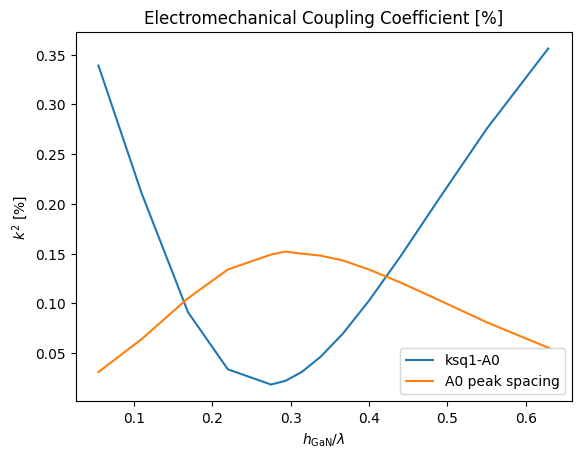

In [16]:
fig, ax = plt.subplots() 
ax.plot( df['hGaN/lambda'], ksq3, label ='ksq1-A0')
ax.plot( undamped_df['hGan/Lambda'], undamped_df[ "Antisymmetric ksq%"], label='A0 peak spacing')
ax.legend()
ax.set_xlabel(r'$h_{\mathrm{GaN}}/\lambda$')
ax.set_title('Electromechanical Coupling Coefficient [%]')
ax.set_ylabel(r'$k^2$ [%]')

In [2]:
filename = 'S0_lambda10.xlsx'
df = pd.read_excel(filename)
df.columns

Index(['freq (Hz)', 'Admittance (S)'], dtype='object')

In [7]:
Ydata[2]

'0.03323392427431093+0.8062567329810865i'

In [85]:


# measured or simulated frequency points (Hz) and complex Y (S)
f = df['freq (Hz)']        # 1-D array
df['Admittance (S)'] = df['Admittance (S)'].str.replace('i', 'j')

# Now convert to complex type
Ydata = df['Admittance (S)'].astype('complex128')
fs = 625094243 #
C0_guess = 8.85e-11
k2_guess = .006
Cm_guess = k2_guess*C0_guess
#Cm_guess = C0_guess/100
Lm_guess = 1/((2*np.pi*fs)**2*Cm_guess)
Q = 3000
Rm_guess = np.sqrt(Lm_guess/Cm_guess)/Q
w = 2*np.pi*f
scale = 1e9 

def Y_bvd(p, w):
    C0, Cm, Lm, Rm = p
    Zm = Rm + 1j*(w*Lm - 1/(w*Cm))
    return 1j*w*C0 + 1/Zm
    
def Y_bvd_scaled(p, w):
    return scale * Y_bvd(p, w)  # compare scaled model to scaled data
    
def residual(p, w, Y):
    return np.hstack((np.real(Y_bvd(p, w) - Y),
                      np.imag(Y_bvd(p, w) - Y)))

p0 = [C0_guess, Cm_guess, Lm_guess, Rm_guess]
bounds = (
    [1e-14, 1e-15, 1e-11, 1e-3],  # lower bounds
    [1e-10, 1e-10, 1e-5, 1e+1],   # upper bounds
)

#sol = least_squares(residual, p0, args=(w, Ydata))
sol = least_squares(
    residual,
    p0,
    args=(w, Ydata),
    #method='trf',
    #xtol=1e-15,
    #ftol=1e-15,
    #gtol=1e-15,
    max_nfev=1000,
    #bounds=bounds
)

C0, Cm, Lm, Rm = sol.x
k2_eff = Cm / (C0 + Cm)
#Qm     = 1/(Rm * w[np.argmin(np.imag(Ydata))] * Cm)
Qm     = np.sqrt(Lm / Cm)/Rm
print(f'k_eff^2 = {k2_eff:.4f},   Q_m = {Qm:.0f}')
print(sol.x)
print(p0)

k_eff^2 = 0.0060,   Q_m = 3000
[8.85000000e-11 5.31000000e-13 1.22082874e-07 1.59830205e-01]
[8.85e-11, 5.310000000000001e-13, 1.220828737962853e-07, 0.1598302050744151]


In [86]:
print('Guess:', p0)
print('Solution:', sol.x)
print('Delta:', sol.x - p0)


Guess: [8.85e-11, 5.310000000000001e-13, 1.220828737962853e-07, 0.1598302050744151]
Solution: [8.85000000e-11 5.31000000e-13 1.22082874e-07 1.59830205e-01]
Delta: [0. 0. 0. 0.]


In [87]:
fp = np.sqrt(fs**2 / (1 - k2_guess))
fstp = (fp - fs) / 333
f_dense = np.linspace(fs - 333*fstp, fp + 333*fstp, 1000)
w_dense = 2 * np.pi * f_dense
Yfit = Y_bvd(sol.x, w_dense)
Yguess = Y_bvd(p0, w_dense)

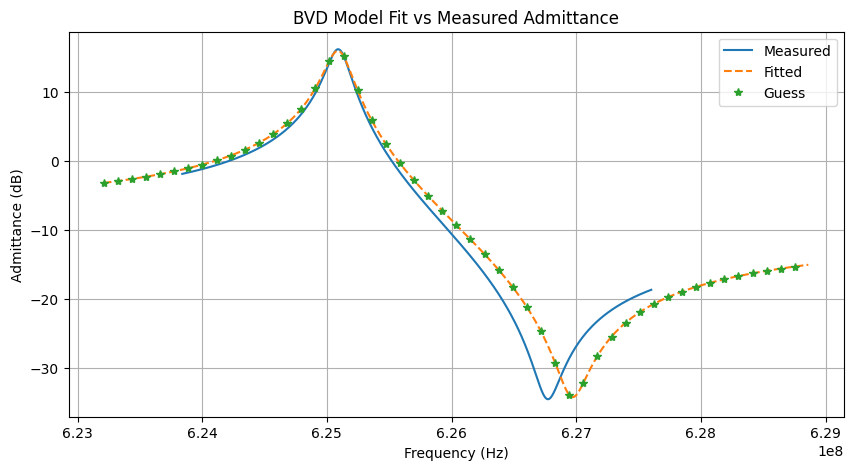

In [88]:


plt.figure(figsize=(10, 5))
plt.plot(f, 20*np.log10(np.abs(Ydata)), label='Measured')
plt.plot(f_dense, 20*np.log10(np.abs(Yfit)), label='Fitted', linestyle='--')
plt.plot(f_dense, 20*np.log10(np.abs(Yguess)), label='Guess', linestyle='none', marker= '*', markevery=20)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Admittance (dB)')
plt.legend()
plt.grid(True)
plt.title('BVD Model Fit vs Measured Admittance')
plt.show()


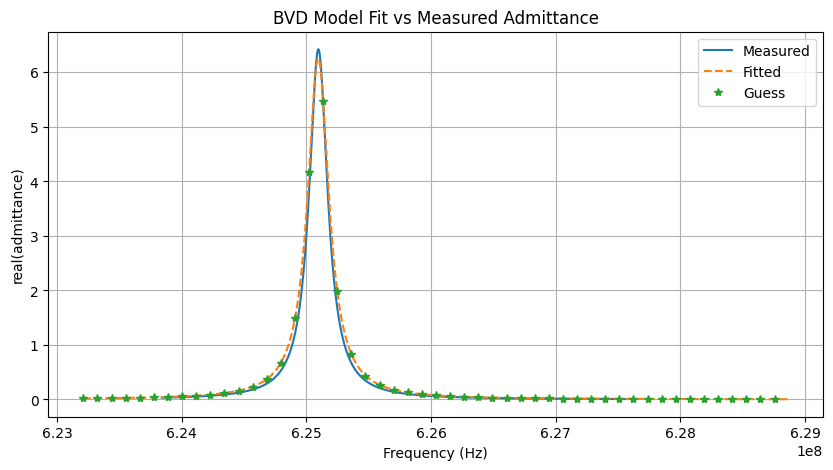

In [80]:
plt.figure(figsize=(10, 5))
plt.plot(f, np.real(Ydata), label='Measured')
plt.plot(f_dense, np.real(Yfit), label='Fitted', linestyle='--')
plt.plot(f_dense, np.real(Yguess), label='Guess', linestyle='none', marker= '*', markevery=20)
plt.xlabel('Frequency (Hz)')
plt.ylabel('real(admittance)')
plt.legend()
plt.grid(True)
plt.title('BVD Model Fit vs Measured Admittance')
plt.show()

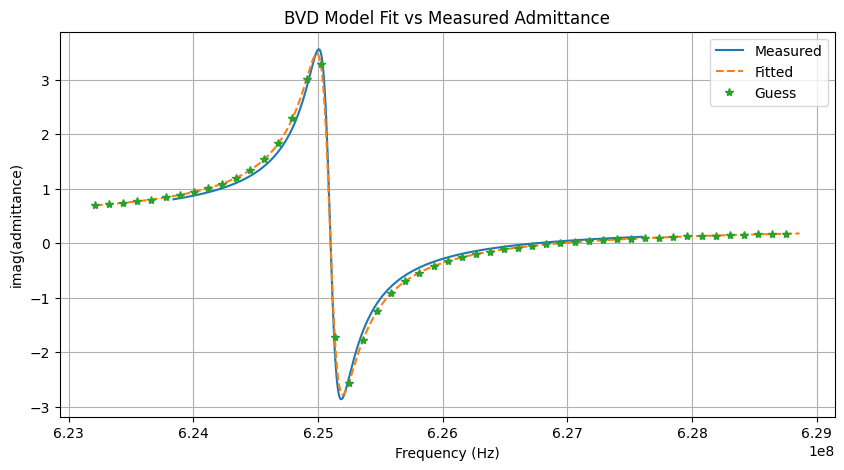

In [82]:
plt.figure(figsize=(10, 5))
plt.plot(f, np.imag(Ydata), label='Measured')
plt.plot(f_dense, np.imag(Yfit), label='Fitted', linestyle='--')
plt.plot(f_dense, np.imag(Yguess), label='Guess', linestyle='none', marker= '*', markevery=20)
plt.xlabel('Frequency (Hz)')
plt.ylabel('imag(admittance)')
plt.legend()
plt.grid(True)
plt.title('BVD Model Fit vs Measured Admittance')
plt.show()